In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
tf.config.list_physical_devices('GPU')
tf.config.experimental.enable_op_determinism()
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
SEED=1234

In [32]:
# Funcion para graficar las curvas de entrenamiento y de validacion
import matplotlib.pyplot as plt
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [33]:
# Cargar el conjunto de datos
datos = pd.read_csv('/content/drive/MyDrive/Inteligencia Artificial/Examenes/Temp_Asu20092021.csv')

In [34]:
# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

In [35]:
# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

In [36]:
# Eliminar filas con valores faltantes
datos.dropna(inplace=True)

In [37]:
# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

In [38]:
# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

In [39]:
# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

In [40]:
# Seleccionar características (por ejemplo,buscar variables adicionales)
X = percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

In [41]:
# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

In [42]:
# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

In [46]:
# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = 1
    tf.keras.utils.set_random_seed(SEED)

    num_capas = 1
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])
    tasa_aprendizaje = trial.suggest_float('tasa_aprendizaje', 1e-5, 1e-1, log=True) # Sugerir tasa de aprendizaje

    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=30, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

In [79]:
# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=100) # 100 trials

[I 2024-09-14 18:31:55,416] A new study created in memory with name: no-name-9003db90-0d1c-4ffc-be91-780d5ed6b33f
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-09-14 18:32:00,034] Trial 0 finished with value: 0.9817351698875427 and parameters: {'num_unidades': 32, 'tasa_aprendizaje': 0.032993647607540685}. Best is trial 0 with value: 0.9817351698875427.
[I 2024-09-14 18:32:03,237] Trial 1 finished with value: 0.9817351698875427 and parameters: {'num_unidades': 32, 'tasa_aprendizaje': 3.7917668790799694e-05}. Best is trial 0 with value: 0.9817351698875427.
[I 2024-09-14 18:32:06,422] Trial 2 finished with value: 0.7336377501487732 and parameters: {'num_unidades': 16, 'tasa_aprendizaje': 0.0010400233

In [80]:
# Obtener los mejores hiperparámetros
mejor_num_capas =  1
mejor_num_unidades = estudio.best_params['num_unidades']
mejor_tasa_aprendizaje = estudio.best_params['tasa_aprendizaje'] # Le agregamos la taza de aprendizaje
print("Mejores Hiperparámetros:")
print("Número de Capas:", 1)
print("Número de Unidades:", mejor_num_unidades)
print("Tasa de Aprendizaje:", mejor_tasa_aprendizaje)

Mejores Hiperparámetros:
Número de Capas: 1
Número de Unidades: 16
Tasa de Aprendizaje: 0.001040023314180537


In [81]:
# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mse',
                     metrics=['mae'])

In [101]:
# Entrenar el modelo final
history=modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)
# Entrenamos el model unas cuantas veces de manera que sea lo más optimo posible

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 24.0787 - mae: 3.7904 - val_loss: 35.5053 - val_mae: 4.6253
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.9880 - mae: 3.7827 - val_loss: 35.3991 - val_mae: 4.6177
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23.8978 - mae: 3.7750 - val_loss: 35.2932 - val_mae: 4.6101
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 23.8081 - mae: 3.7673 - val_loss: 35.1876 - val_mae: 4.6025
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.7191 - mae: 3.7597 - val_loss: 35.0824 - val_mae: 4.5949
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 23.6306 - mae: 3.7521 - val_loss: 34.9775 - val_mae: 4.5873
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 23.5428 - mae: 3.7445 - val_loss: 34.8732 - val_mae: 4.5797
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 23.4558 - mae: 3.7370 - val_loss: 34.7701 - val_mae: 4.5722
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 23.3695

In [102]:
# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')

MAE en validación: [30.79990577697754, 4.272008419036865]


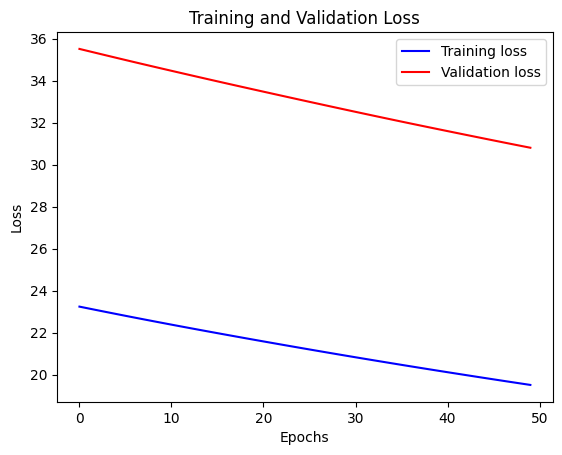

In [103]:
visualize_loss(history, "Training and Validation Loss")

curvas de entreamiento y validacion usando la métrica mae

In [104]:
# Ejemplo de como calcular las otras metricas que podrias utilizarse como funcion objetivo para la optimizacion de hiperparametros en lugar del mae
y_pred = modelo_final.predict(X_validacion)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las predicciones en clases

precision = precision_score(np.argmax(y_validacion, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(y_validacion, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(y_validacion, axis=1), y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# Usemos ahora la métrica recall

In [105]:
# Definir función objetivo para Optuna con matric precicson
def objetivo(trial):
    num_capas = 1
    tf.keras.utils.set_random_seed(SEED)

    num_capas = 1
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])
    tasa_aprendizaje = trial.suggest_float('tasa_aprendizaje', 1e-5, 1e-1, log=True) # Sugerir tasa de aprendizaje

    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['recall'])  # recall

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=30, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

In [106]:
# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=100)

[I 2024-09-14 18:42:25,343] A new study created in memory with name: no-name-bda9db33-afdc-45db-ac37-5711c41c247a
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-09-14 18:42:31,255] Trial 0 finished with value: 1.0 and parameters: {'num_unidades': 64, 'tasa_aprendizaje': 0.000987123166828592}. Best is trial 0 with value: 1.0.
[I 2024-09-14 18:42:34,395] Trial 1 finished with value: 0.9817351698875427 and parameters: {'num_unidades': 32, 'tasa_aprendizaje': 1.6555722564195027e-05}. Best is trial 1 with value: 0.9817351698875427.
[I 2024-09-14 18:42:37,684] Trial 2 finished with value: 1.0 and parameters: {'num_unidades': 64, 'tasa_aprendizaje': 4.565574753756564e-05}. Best is trial 1 with value: 0.981

In [107]:
# Obtener los mejores hiperparámetros
mejor_num_capas =  1
mejor_num_unidades = estudio.best_params['num_unidades']
mejor_tasa_aprendizaje = estudio.best_params['tasa_aprendizaje'] # Le agregamos la taza de aprendizaje
print("Mejores Hiperparámetros:")
print("Número de Capas:", 1)
print("Número de Unidades:", mejor_num_unidades)
print("Tasa de Aprendizaje:", mejor_tasa_aprendizaje)

Mejores Hiperparámetros:
Número de Capas: 1
Número de Unidades: 16
Tasa de Aprendizaje: 0.04900370287823622


In [109]:
# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mse',
                     metrics=['recall'])

In [123]:
# Entrenar el modelo final
history=modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=50, batch_size=256, verbose=1, shuffle=False)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 52.4142 - recall: 1.0000 - val_loss: 65.0269 - val_recall: 1.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 51.9954 - recall: 1.0000 - val_loss: 64.5653 - val_recall: 1.0000
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 51.5812 - recall: 1.0000 - val_loss: 64.1104 - val_recall: 1.0000
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 51.1723 - recall: 1.0000 - val_loss: 63.6622 - val_recall: 1.0000
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 50.7686 - recall: 1.0000 - val_loss: 63.2197 - val_recall: 1.0000
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 50.3695 - recall: 1.0000 - val_loss: 62.7845 - val_recall: 1.0000
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 49.9759 - recall: 1.0000 - val_loss: 62.3555 - val_recall: 1.0000
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 49.5873 - recall: 1.0000 - val_loss: 61.9331 - val_recall: 1.0000
Epoch 9/50
4/4 ━

In [124]:
# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'Precision en recall: {recall}')

Precision en recall: 1.0


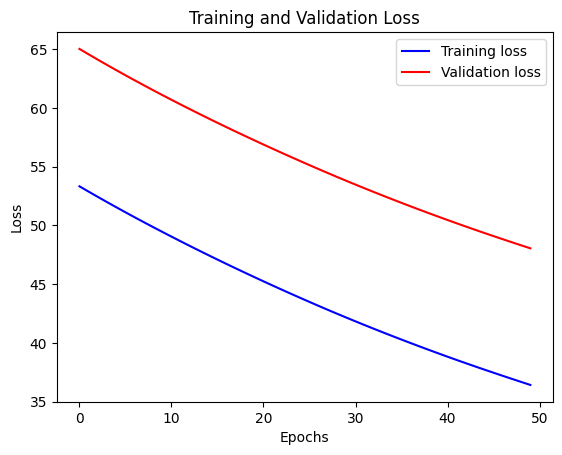

In [125]:
visualize_loss(history, "Training and Validation Loss")

curvas de entrenamiento y validacion usando la métrica recall

# Como observamos en los graficos, ambas métricas dan como resultado un modelo de predicción eficaz.